In [1]:
import os
import sys
from datetime import datetime, timezone, timedelta
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from scipy import stats
from tqdm.notebook import tqdm
from functools import partial
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, multilabel_confusion_matrix
from time import perf_counter

In [2]:
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

In [3]:
from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Utility functions

## Plotting - fixed numbers of clusters and observations

In [4]:
# Plotting for training with fixed numbers of clusters and observations

def plot_confusion_matrix(m_true, m_pred, model_names, ax, normalize=True, 
                          cmap=plt.cm.Blues, annotate=True):
    """
    Helper function to print and plot the confusion matrix. 
    Normalization can be applied by setting `normalize=True`.
    """


    # Compute confusion matrix
    cm = confusion_matrix(m_true, m_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=model_names, yticklabels=model_names,
           ylabel='True Model',
           xlabel='Predicted Model')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if annotate:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    ax.set_title('Confusion Matrix')

    
def plot_calibration_curve(m_true, m_pred, n_bins, ax, title='Calibration'):
    """Helper function to plot calibration curve and ece."""
    
    prob_true, prob_pred = calibration_curve(m_true, m_pred, n_bins=n_bins)
    cal_err = np.mean(np.abs(prob_true - prob_pred))
    ax.plot(prob_true, prob_pred)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.plot(ax.get_xlim(), ax.get_xlim(), '--')
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Confidence')
    ax.text(0.1, 0.9,  'ECE = {0:.3f}'.format(cal_err),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.set_title(title)
    sns.despine(ax=ax)
    
    
def plot_bootstrap_accuracy(m_true, m_pred, n_bootstrap, ax):
    """Helper function to plot the bootstrap accuracy of recovery."""
    
    
    n_test = m_true.shape[0]
    accs = []
    for bi in range(n_bootstrap):
        b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
        m_true_b, m_pred_b = m_true[b_idx], m_pred[b_idx]
        accs.append(accuracy_score(m_true_b, m_pred_b))
    
    sns.histplot(accs, ax=ax, stat='probability')
    sns.despine(ax=ax)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.yaxis.set_ticks([])
    ax.text(0.05, 0.9,  'Bootstrap accuracy = {0:.3f}'.format(np.mean(accs)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.05, 0.8,  'SD = {0:.3f}'.format(np.std(accs)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    
    
def plot_bootstrap_mae(m_true, m_pred, n_bootstrap, ax):
    """Helper function to plot the bootstrap accuracy of recovery."""
    
    
    n_test = m_true.shape[0]
    maes = []
    for bi in range(n_bootstrap):
        b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
        m_true_b, m_pred_b = m_true[b_idx], m_pred[b_idx]
        maes.append(mean_absolute_error(m_true_b, m_pred_b))
    
    sns.histplot(maes, ax=ax, stat='probability')
    sns.despine(ax=ax)
    ax.set_xlabel('MAE')
    ax.set_ylabel('')
    ax.yaxis.set_ticks([])
    ax.text(0.05, 0.9,  'Mean MAE = {0:.3f}'.format(np.mean(maes)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.05, 0.8,  'SD = {0:.3f}'.format(np.std(maes)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    

def perf_tester(evidence_net, summary_net, val_data, n_bootstrap=100, n_cal_bins=15):
    """Utility function to test the performance of the model."""
    
    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
    m_hard = (m_soft > 0.5).astype(np.int32)
    m_true = val_data['m'][:, 1]
    
    # Prepare figures
    fig, axarr = plt.subplots(2, 2, figsize=(16, 8))
    
    # Plot stuff
    plot_calibration_curve(m_true, m_soft, n_cal_bins, axarr[0, 0])
    plot_confusion_matrix(m_true, m_hard, ['M1', 'M2'], axarr[0, 1])
    plot_bootstrap_accuracy(m_true, m_hard, n_bootstrap, axarr[1, 0])
    plot_bootstrap_mae(m_true, m_hard, n_bootstrap, axarr[1, 1])
    fig.tight_layout()

## Plotting - fixed numbers of clusters and variable number of observations

In [5]:
# Plotting for training with fixed numbers of clusters and variable number of observations

def plot_eces_over_obs(m_true, m_pred, n_obs_min, n_obs_max, n_bins):
    """Helper function to plot ece as a function of N."""

    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)
    prob_true, prob_pred, cal_err = ([] for i in range(3))
    
    for i in range(n_obs_max-(n_obs_min-1)):
        prob_true_i, prob_pred_i = calibration_curve(m_true[i], m_pred[i], n_bins=n_bins)
        prob_true.append(prob_true_i)
        prob_pred.append(prob_pred_i)
        cal_err_i = np.mean(np.abs(prob_true[i] - prob_pred[i]))
        cal_err.append(cal_err_i)
    ax.plot(n_obs_points, cal_err)
    mean_ece = np.mean(cal_err)
    sd_ece = np.std(cal_err)
    plt.axhline(y=mean_ece, color='tab:red')
    plt.fill_between(n_obs_points, mean_ece-3*sd_ece, mean_ece+3*sd_ece, 
                     color='tab:red', alpha=0.1)
    ax.set_xlim([n_obs_min, n_obs_max])
    ax.set_ylim([0, 1])
    ax.set_xlabel('N')
    ax.set_ylabel('ECE')
    ax.text(0.1, 0.9,  'Mean ECE = {0:.3f}'.format(mean_ece),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.1, 0.85,  'Shaded region: Mean ECE +/- 3SD ',
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)    
    ax.set_title('Expected Calibration Error (ECE)')    


def perf_tester_over_obs(evidence_net, summary_net, val_data, n_obs_min, n_obs_max, n_bootstrap=100, n_cal_bins=15):
    """Utility function to test the performance of the model."""
    
    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft, m_hard, m_true = ([] for i in range(3))
    
    for i in range(n_obs_max-(n_obs_min-1)):
        m_soft_i = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'][i], 5)], axis=0).numpy()
        m_soft.append(m_soft_i)
        m_hard_i = (m_soft[i] > 0.5).astype(np.int32)
        m_hard.append(m_hard_i)
        m_true_i = val_data['m'][i][:, 1]
        m_true.append(m_true_i)

    # Plot stuff
    plot_eces_over_obs(m_true, m_soft, n_obs_min, n_obs_max, n_cal_bins)

## Plotting - variable numbers of clusters and variable number of observations

In [6]:
# Plotting for training with variable numbers of clusters and variable number of observations

def compute_eces_variable(evidence_net, summary_net, simulator, n_val_per_setting, n_clust_min, n_clust_max, n_obs_min, n_obs_max, n_cal_bins=15):
    """
    Simulates validation data per setting and computes the expected calibration error of the model.
    --------

    Returns:
    2 lists of shape((n_clust_max+1 - n_clust_min)*(n_obs_max+1 - n_obs_min)) 
    - containing the mean (1st list) / sd (2nd list) eces of all possible combinations on L and N.
    """
    
    def n_clust_obs_f_v_val(l, n):
        """
        Nasty hack to make compatible with BayesFlow.
        Defines a fixed number of clusters and a number of observations that is iterated through.
        """
        
        K = l
        N = n
        return (K, N)
    
    # Create lists
    ece_means = []
    
    with tqdm(total=(n_clust_max+1 - n_clust_min), desc='Loop through clusters progress') as p_bar: 
        with tqdm(total=(n_obs_max+1 - n_obs_min), desc='Loop through nested observations progress') as p_bar_within:
            for l in range(n_clust_min, n_clust_max+1): # Loop through clusters
                
                p_bar_within.reset((n_obs_max+1 - n_obs_min)) # reuse 2nd bar so that screen doesn't explode
                for n in range(n_obs_min, n_obs_max+1): # Loop through nested observations

                    # Simulate validation data
                    m_val_sim, _, x_val_sim = simulator(n_val_per_setting, n_clust_obs_f_v_val(l, n))

                    # Predict model probabilities
                    #m_soft = evidence_net.predict(summary_net(x_val_sim))['m_probs'][:, 1]
                    m_soft = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(x_val_sim, 20)], axis=0).numpy()      
                    m_true = m_val_sim[:, 1]  

                    # Compute calibration error
                    prob_true, prob_pred = calibration_curve(m_true, m_soft, n_bins=n_cal_bins)
                    cal_err = np.abs(prob_true - prob_pred)

                    mean_ece = np.mean(cal_err)
                    ece_means.append(mean_ece)

                    # Update inner progress bar
                    p_bar_within.set_postfix_str("Cluster {0}, Observation {1}".format(l, n + 1))
                    p_bar_within.update()

                # Refresh inner + update outer progress bar
                p_bar_within.refresh() 
                p_bar.set_postfix_str("Finished clusters: {}".format(l))
                p_bar.update()
    
    return(ece_means)


def plot_eces_variable(ece_means, n_clust_min, n_clust_max, n_obs_min, n_obs_max):
    """ 
    Takes the ECE results from compute_eces_variable() and 
    projects them onto a 3D-plot.
    """
    
    # Prepare objects
    #f = plt.figure(figsize=(16, 16))
    f = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection='3d')

    n_clust_points = np.arange(n_clust_min, n_clust_max+1)
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)

    n_clust_grid, n_obs_grid = np.meshgrid(n_clust_points, n_obs_points)
    cal_err_grid = np.reshape(ece_means, (-1, n_clust_max)) # reshape into (#clusters, #observations)
    ax.plot_surface(n_clust_grid, n_obs_grid, cal_err_grid, cmap='coolwarm', edgecolor='none')

    ax.elev = 15
    ax.set_xlim([n_clust_min, n_clust_max]) 
    ax.set_ylim([n_obs_max, n_obs_min])
    ax.set_zlim([0, 0.3])
    ax.set_xlabel('$J$')
    ax.set_ylabel('$N$')    
    ax.set_zlabel('ECE')
    ax.text2D(0.05, 0.95, 'Mean ECE = {0:.3f}'.format(np.mean(ece_means)), transform=ax.transAxes)
    ax.text2D(0.05, 0.90, 'SD around mean ECE = {0:.3f}'.format(np.std(ece_means)), transform=ax.transAxes)
    #ax.set_title('Expected Calibration Error (ECE)')
    #f.savefig('Calibration_variable_TeaP.png', dpi=300, bbox_inches='tight')
    
def plot_eces_means_over_obs(ece_means_over_N, ece_means_over_N_sd, n_obs_min, n_obs_max, xlabel='$N$', n_bins=15):
    """Helper function to plot ece as a function of N (or L)."""

    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)
    
    ax.plot(n_obs_points, ece_means_over_N, color='black')
    mean_ece = np.mean(ece_means_over_N)
    plt.axhline(y=mean_ece, linestyle='--', color='darkgrey')
    ax.set_xlim([n_obs_min, n_obs_max])
    ax.set_ylim([0, 0.4])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('ECE')
    #ax.set_title('Expected Calibration Error (ECE)')

# Simulator classes

In [7]:
class HierarchicalNormalSimulator:
    
    def __init__(self):    
        pass
    
    def draw_from_prior(self, model_index, n_clusters, mu0, tau20, sigma_t, sigma_s):
        """
        Draws parameter values from the specified prior distributions of the 
        hyperprior and the conditional prior.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        """
        
        if model_index == 0: 
            mu = 0
        if model_index == 1:
            mu = np.random.normal(loc=mu0, scale=np.sqrt(tau20))
            
        tau2 = stats.halfnorm.rvs(scale=sigma_t)
        sigma2 = stats.halfnorm.rvs(scale=sigma_s)
        theta = np.random.normal(loc=mu, scale=np.sqrt(tau2), size=n_clusters)
        return theta, sigma2
    
    def gen_from_likelihood(self, theta, sigma2, n_obs):
        """
        Generates a single hierarchical dataset from the sampled parameter values.
        ----------
        
        Arguments: 
        params : list -- parameters sampled from prior 
        n_obs  : int -- number of observations per cluster
        """
        
        X = np.random.normal(loc=theta, scale=sigma2, size=(n_obs, theta.shape[0])).T 
        return X
    
    def generate_single(self, model_index, n_clusters, n_obs, mu0=0, tau20=1, sigma_t=1, sigma_s=1):
        """
        Generates a single hierarchical dataset utilizing the draw_from_prior and gen_from_likelihood functions.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        --------
        
        Returns:
        numpy array of shape (n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        theta, sigma2 = self.draw_from_prior(model_index, n_clusters, mu0, tau20, sigma_t, sigma_s)
        x_generated = self.gen_from_likelihood(theta, sigma2, n_obs)
        return x_generated[...,np.newaxis]
        
    def simulate(self, batch_size, n_models, n_clusters, n_obs, mu0=0, tau20=1, sigma_t=1, sigma_s=1):
        """
        Simulates multiple hierarchical datasets. Useful for single usage and debugging (both without the MainSimulator).
        ----------
        
        Arguments:
        batch_size  : int -- number of batches to be generated
        n_models    : int -- number of models to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        n_variables : int -- number of variables in the simulated datasets 
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        --------
        
        Returns:
        numpy array of shape (batch_size * n_models, n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        
        X = []
        for b in range(batch_size):
            prior_sample = self.draw_from_prior(n_clusters, mu0, tau20, sigma_t, sigma_s)
            x_generated = self.gen_from_likelihood(prior_sample, n_obs)
            X.append(x_generated)
        return np.array(X)[...,np.newaxis]

In [8]:
class MainSimulator:
    
    def __init__(self, simulator):
        
        self.simulator = simulator
    
    def draw_from_model_prior(self, batch_size, n_models, model_prior):
        """
        Creates the sequence of models to be simulated from in the batch.
        ----------
        
        Arguments:
        batch_size     : int -- number of batches to be generated
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        --------
        
        Returns:
        array of shape (batch_size) - array of indices corresponding to the sampled model from p(M).
        """
        
        # create base list of model indices
        model_base_indices = [*range(n_models)]
        
        # uniform prior over model probabilities if no model prior given
        if model_prior == None:
            model_prior = [1/n_models] * n_models
        
        # generate sampling list of model indeces
        model_indices = np.random.choice(model_base_indices, size=batch_size, p=model_prior)
        return model_indices
    
    def simulate(self, batch_size, n_obs, n_models, model_prior, 
                 n_clust_min=2, n_clust_max=100, n_obs_min=2, n_obs_max=200):
        """
        Simulates a batch of hierarchical datasets.
        ----------
        
        Arguments:
        batch_size     : int -- number of datasets to be generated per batch
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        n_clust_min    : int -- minimum number of clusters
        n_clust_max    : int -- maximum number of cluster
        n_obs_min      : int -- minimum number of observations
        n_obs_max      : int -- maximum number of observations
        --------
        
        Returns:
        dict of {'X' : array of shape (batch_size, n_clusters, n_obs, n_variables),  
                 'm' : array of shape (batch_size)}
        """
        # Draw K and N (drawn values apply for all datasets in the batch)
        K, N = n_obs
        
        # Draw sampling list of model indices
        model_indices = self.draw_from_model_prior(batch_size, n_models, model_prior)
        
        # Prepare an array to hold simulations
        X_gen = np.zeros((batch_size, K, N, 1), dtype=np.float32)
        
        for b in range(batch_size):
            X_gen[b] = self.simulator.generate_single(model_indices[b], K, N)
               
        return to_categorical(model_indices), None, X_gen
    
    def __call__(self, batch_size, n_obs, n_models=2, model_prior=None):
        return self.simulate(batch_size, n_obs, n_models, model_prior)

# Neural networks

In [9]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta, pooler=tf.reduce_mean):
        """
        Creates an invariant function with mean pooling.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the invariant module
        """
        
        super(InvariantModule, self).__init__()
        
        # Pre pooling network
        self.pre_pooling_dense = tf.keras.Sequential([tf.keras.layers.Dense(**meta['dense_inv_pre_pooling_args'])
                                                     for _ in range(meta['n_dense_inv'])])
        
        self.pooler = pooler
        
        # Post pooling network
        self.post_pooling_dense = tf.keras.Sequential([tf.keras.layers.Dense(**meta['dense_inv_post_pooling_args'])
                                                      for _ in range(meta['n_dense_inv'])])
        
            
    def call(self, x):
        """
        Transforms the input into an invariant representation.
        ----------
        
        Arguments:
        x : tf.Tensor of variable shape - 4-dimensional with (batch_size, n_clusters, n_obs, n_variables)
                                          or 3-dimensional with (batch_size, n_clusters, inv_embedding)
        --------
        
        Returns:
        out: tf.Tensor of variable shape - either 3-dimensional (when input is 4D) with (batch_size, n_clusters, inv_embedding)
                                           or 2-dimensional (when input is 3D) with (batch_size, inv_embedding)
        """
        
        # Embed input before pooling
        x_emb = self.pre_pooling_dense(x)
        
        # Perform mean pooling, shape of pooled is (batch_size, K, dense_out)
        pooled = self.pooler(x_emb, axis=-2) # always reduce dimensionality of the lowest exchangable data level

        # Increase representational power
        out = self.post_pooling_dense(pooled)
        return out
    
    
class EquivariantModule(tf.keras.Model):
    
    def __init__(self, meta):
        """
        Creates an equivariant function.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the equivariant module
        """
        
        super(EquivariantModule, self).__init__()
        
        self.inv = InvariantModule(meta['inv_inner'])
        self.equiv = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_equiv_args'])
            for _ in range(meta['n_dense_equiv'])]
        )
        
    def call(self, x):
        """
        Performs an equivariant transformation using both equiv and inv transforms.
        """

        n_rep = x.shape[-2]
        inv = self.inv(x)
        inv = tf.stack([inv] * n_rep, axis=-2)
        inp = tf.concat([x, inv], axis=-1)
        out = self.equiv(inp)
        return out
    
    
class InvariantNetwork(tf.keras.Model):
    
    def __init__(self, meta, pooler=tf.reduce_mean):
        """
        Creates an invariant network consisting of equivariant and invariant functions.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the invariant network
        """
        
        super(InvariantNetwork, self).__init__()
        
        self.inv = InvariantModule(meta['inv_outer'])
        self.equiv = tf.keras.Sequential([
                EquivariantModule(meta)
            for _ in range(meta['n_equiv'])
        ])
        
    def call(self, x):
        """
        Performs an invariant transformation using both equiv and inv transforms.
        """

        out = self.equiv(x)
        out = self.inv(out)
        return out
    
    
class HierarchicalInvariantNetwork(tf.keras.Model):
    """
    Implements a network that is able to summarize hierarchical data.
    """
    
    def __init__(self, meta):
        """
        Creates a hierarchical Network consisting of two stacked invariant modules.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the hierarchical network
        """
        
        super(HierarchicalInvariantNetwork, self).__init__()
        
        self.inv_4d = InvariantNetwork(meta['level_1'])
        self.inv_3d = InvariantNetwork(meta['level_2'])
        
        
    def call(self, x):
        """
        Transforms the 4-dimensional input into learned summary statistics.
        ----------
        
        Arguments:
        x : tf.Tensor of shape (batch_size, n_clusters, n_obs, n_variables) -- simulated data
        --------
        
        Returns:
        out : tf.Tensor of shape (batch_size, (dense_inv_post_pooling_args on level_2) + 2) -- the learned summary statistics
        """

        # Pass through invariant networks
        out = self.inv_4d(x)
        out = self.inv_3d(out)

        # Extract number of clusters and observations into a repeated vector and concatenate with network output
        n_clust = int(x.shape[-3])
        n_clust_rep = tf.math.sqrt(n_clust * tf.ones((x.shape[0], 1)))
        out = tf.concat((out, n_clust_rep), axis=-1)

        n_obs = int(x.shape[-2])
        n_obs_rep = tf.math.sqrt(n_obs * tf.ones((x.shape[0], 1)))
        out = tf.concat((out, n_obs_rep), axis=-1)

        return out
    
    
class EvidentialNetwork(tf.keras.Model):
    """
    Implements a network that infers the parameters of a dirichlet distribution in order to quantify model evidences.
    """
    
    def __init__(self, meta):
        """
        Creates an evidential network.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the evidential network
        """
        
        super(EvidentialNetwork, self).__init__()
        
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_args'])
            for _ in range(meta['n_dense'])
        ])
        self.evidence_layer = tf.keras.layers.Dense(meta['n_models'], activation=meta['activation_out'])
        self.J = meta['n_models']
        
      
    def call(self, x):
        """
        Forward pass through the evidential network.
        """
        
        out = self.dense(x)
        alpha = self.evidence_layer(out) + 1
        return alpha
        
    def predict(self, obs_data, to_numpy=True):
        """
        Returns the mean, variance and uncertainty implied by the estimated Dirichlet density.

        Parameters
        ----------
        obs_data: tf.Tensor
            Observed data
        to_numpy: bool, default: True
            Flag that controls whether the output is a np.array or tf.Tensor

        Returns
        -------
        out: dict
            Dictionary with keys {m_probs, m_var, uncertainty}
        """

        alpha = self(obs_data)
        alpha0 = tf.reduce_sum(alpha, axis=1, keepdims=True)
        mean = alpha / alpha0
        var = alpha * (alpha0 - alpha) / (alpha0 * alpha0 * (alpha0 + 1))
        uncertainty = self.J / alpha0

        if to_numpy:
            mean = mean.numpy()
            var = var.numpy()
            uncertainty = uncertainty.numpy()

        return {'m_probs': mean, 'm_var': var, 'uncertainty': uncertainty}
    
    def sample(self, obs_data, n_samples, to_numpy=True):
        """Samples posterior model probabilities from the second-order Dirichlet distro.

        Parameters
        ----------
        obs_data  : tf.Tensor
            The summary of the observed (or simulated) data, shape (n_datasets, summary_dim)
        n_samples : int
            Number of samples to obtain from the approximate posterior
        to_numpy  : bool, default: True
            Flag indicating whether to return the samples as a np.array or a tf.Tensor

        Returns
        -------
        pm_samples : tf.Tensor or np.array
            The posterior samples from the Dirichlet distribution, shape (n_samples, n_batch, n_models)
        """

        # Compute evidential values
        alpha = self(obs_data)
        n_datasets = alpha.shape[0]

        # Sample for each dataset
        pm_samples = np.stack([np.random.dirichlet(alpha[n, :], size=n_samples) for n in range(n_datasets)], axis=1)

        # Convert to tensor, if specified
        if not to_numpy:
             pm_samples = tf.convert_to_tensor(pm_samples, dtype=tf.float32)
        return pm_samples

# Experiments

## Network settings

In [10]:
# Network settings for all experiments
summary_meta = {
    'level_1': {
        'inv_inner': {
            'dense_inv_pre_pooling_args'  : dict(units=8, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=8, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'inv_outer': {
            'dense_inv_pre_pooling_args'  : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'dense_equiv_args': dict(units=16, activation='elu', kernel_initializer='glorot_normal'),
        'n_dense_equiv': 2,
        'n_equiv': 2,
    },
    'level_2': {
        'inv_inner': {
            'dense_inv_pre_pooling_args'  : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'inv_outer': {
            'dense_inv_pre_pooling_args'  : dict(units=128, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=128, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'dense_equiv_args': dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
        'n_dense_equiv': 2,
        'n_equiv': 2,
    },
}
evidence_meta = {
    'dense_args': dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'n_dense': 2,
    'n_models': 2,
    'activation_out': 'softplus'
}

In [11]:
summary_net = HierarchicalInvariantNetwork(summary_meta)
evidence_net = EvidentialNetwork(evidence_meta)

In [12]:
amortizer = MultiModelAmortizer(evidence_net, summary_net)

In [13]:
simulator = MainSimulator(HierarchicalNormalSimulator())

In [14]:
# Cosine Decay with Restarts

initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha)

trainer = ModelComparisonTrainer(network=amortizer, 
                                 generative_model=simulator, 
                                 loss=partial(log_loss, kl_weight=0),
                                 optimizer=partial(Adam, lr_schedule_restart),
                                 skip_checks=True)

## Training with fixed number of clusters and observations

In [15]:
def n_clust_obs_f_f():
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a fixed number of clusters and observations.
    """
    
    K = 50
    N = 50
    return (K, N)

training_time_start = perf_counter()
losses = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32, n_obs=n_clust_obs_f_f)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
# Validation
n_val = 5000
m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

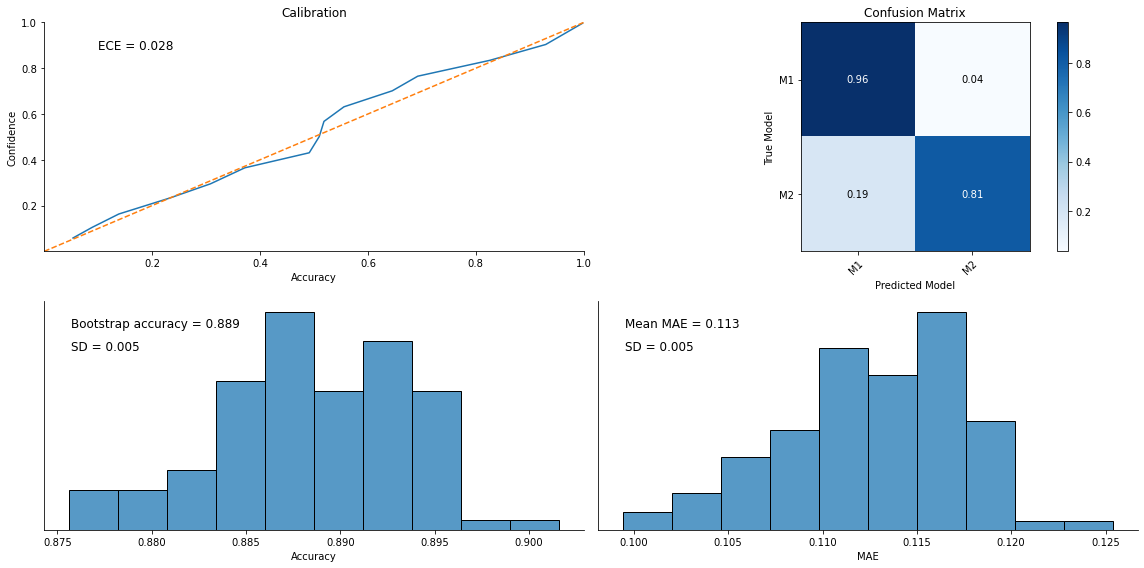

In [51]:
perf_tester(evidence_net, summary_net, val_data, n_cal_bins=15)

0.028298580900255055


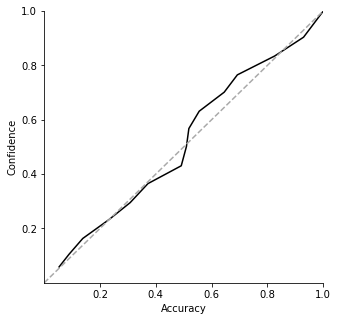

In [54]:
# Plotting for thesis

probs = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
true_models = val_data['m'][:, 1]

#fig, ax = plt.subplots(figsize=(10,10))
fig, ax = plt.subplots(figsize=(5,5))

prob_true, prob_pred = calibration_curve(true_models, probs, n_bins=15)
cal_err = np.mean(np.abs(prob_true - prob_pred))
print(cal_err)
ax.plot(prob_true, prob_pred, color='black')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='darkgrey')
ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlabel('Accuracy')
ax.set_ylabel('Confidence')
sns.despine(ax=ax)
#fig.savefig('Calibration_fixed_TeaP.png', dpi=300, bbox_inches='tight')

## Training with fixed numbers of clusters and variable number of observations

In [27]:
n_obs_min = 1
n_obs_max = 100

def n_clust_obs_f_v():
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a fixed number of clusters and a variable number of observations.
    """
    
    K = 50
    N = np.random.randint(n_obs_min, n_obs_max)
    return (K, N)

training_time_start = perf_counter()
losses = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32, n_obs=n_clust_obs_f_v)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
# apply nasty hack to validation data generation to work with BayesFlow simulator
def n_clust_obs_f_v_val(n):
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a fixed number of clusters and a number of observations that is iterated through.
    """
    
    K = 50
    N = n
    return (K, N)

# Generate data for each setting
n_val_per_setting = 5000

m_val = []
x_val = []
for n in range(n_obs_min, n_obs_max+1):
    m_val_sim, _, x_val_sim = simulator(n_val_per_setting, n_clust_obs_f_v_val(n))
    m_val.append(m_val_sim)
    x_val.append(x_val_sim)
    if n%25 == 0:
        print('Iteration {} finished'.format(n))

val_data = {'X' : x_val, 'm' : m_val}

Iteration 25 finished
Iteration 50 finished
Iteration 75 finished
Iteration 100 finished


Wall time: 25.9 s


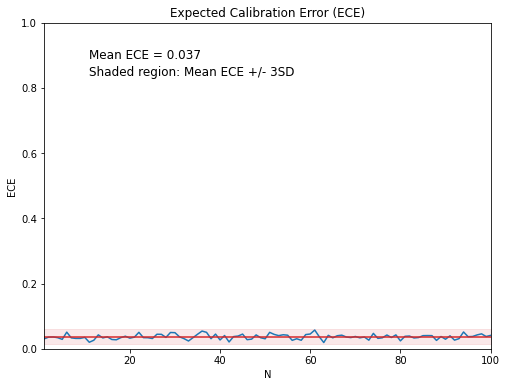

In [29]:
%%time

perf_tester_over_obs(evidence_net, summary_net, val_data, n_obs_min, n_obs_max)

In [30]:
# Plotting for thesis

def plot_eces_over_obs_thesis(m_true, m_pred, n_obs_min, n_obs_max, n_bins):
    """Helper function to plot ece as a function of N."""

    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)
    prob_true, prob_pred, cal_err = ([] for i in range(3))
    
    for i in range(n_obs_max-(n_obs_min-1)):
        prob_true_i, prob_pred_i = calibration_curve(m_true[i], m_pred[i], n_bins=n_bins)
        prob_true.append(prob_true_i)
        prob_pred.append(prob_pred_i)
        cal_err_i = np.mean(np.abs(prob_true[i] - prob_pred[i]))
        cal_err.append(cal_err_i)
    ax.plot(n_obs_points, cal_err, color='black')
    mean_ece = np.mean(cal_err)
    print(mean_ece)
    #sd_ece = np.std(cal_err)
    plt.axhline(y=mean_ece, linestyle='--', color='darkgrey')
    #plt.fill_between(n_obs_points, mean_ece-3*sd_ece, mean_ece+3*sd_ece, 
    #                 color='tab:red', alpha=0.1)
    ax.set_xlim([n_obs_min, n_obs_max])
    ax.set_ylim([0, 0.4])
    ax.set_xlabel('$N$')
    ax.set_ylabel('ECE')
    print(cal_err[:5])

def perf_tester_over_obs_thesis(evidence_net, summary_net, val_data, n_obs_min, n_obs_max, n_bootstrap=100, n_cal_bins=15, save=False):
    """Utility function to test the performance of the model."""
    
    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft, m_hard, m_true = ([] for i in range(3))
    
    for i in range(n_obs_max-(n_obs_min-1)):
        m_soft_i = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'][i], 5)], axis=0).numpy()
        m_soft.append(m_soft_i)
        m_hard_i = (m_soft[i] > 0.5).astype(np.int32)
        m_hard.append(m_hard_i)
        m_true_i = val_data['m'][i][:, 1]
        m_true.append(m_true_i)

    # Plot stuff
    if save == False:
        plot_eces_over_obs_thesis(m_true, m_soft, n_obs_min, n_obs_max, n_cal_bins)
    if save == True:
        cal_err = save_eces_over_obs(m_true, m_soft, n_obs_min, n_obs_max, n_cal_bins)
        return cal_err
    
def save_eces_over_obs(m_true, m_pred, n_obs_min, n_obs_max, n_bins):
    """Helper function to plot ece as a function of N."""
    
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)
    prob_true, prob_pred, cal_err = ([] for i in range(3))
    
    for i in range(n_obs_max-(n_obs_min-1)):
        prob_true_i, prob_pred_i = calibration_curve(m_true[i], m_pred[i], n_bins=n_bins)
        prob_true.append(prob_true_i)
        prob_pred.append(prob_pred_i)
        cal_err_i = np.mean(np.abs(prob_true[i] - prob_pred[i]))
        cal_err.append(cal_err_i)
        
    return cal_err

0.03679950498082135
[0.03060395380621559, 0.03579741499751844, 0.036305752432071105, 0.034042407510824775, 0.028940941603039942]


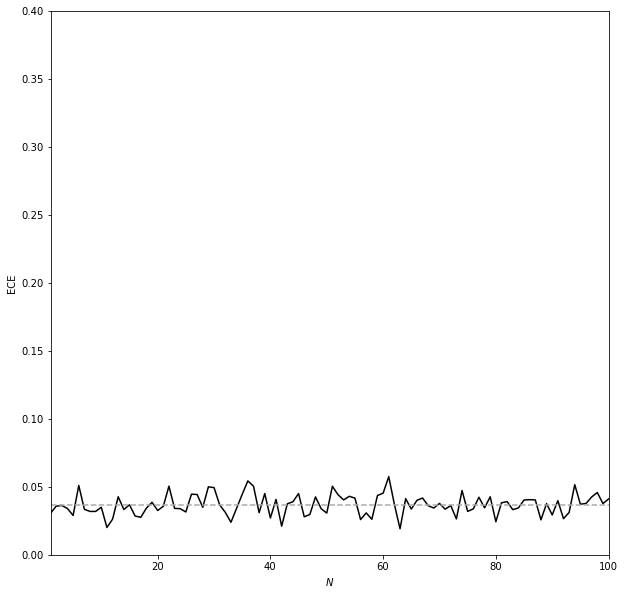

In [31]:
perf_tester_over_obs_thesis(evidence_net, summary_net, val_data, n_obs_min, n_obs_max)

In [32]:
# Export ECE data 
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_fixed_clusters_variable_obs_eces_n_obs_min=2')
val_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'Validation_datasets')
ece_means = perf_tester_over_obs_thesis(evidence_net, summary_net, val_data, n_obs_min, n_obs_max, save=True)
np.save(os.path.join(val_folder, filename), ece_means)

In [87]:
# Load ECE data
val_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'Validation_datasets')
ece_filename = "2021_09_01___14_57_fixed_clusters_variable_obs_eces_n_obs_min=2.npy"
ece_means = np.load(os.path.join(val_folder, ece_filename))

## Training with variable numbers of clusters and observations

In [23]:
n_clust_min = 1
n_clust_max = 100
n_obs_min = 1
n_obs_max = 100

def n_clust_obs_v_v():
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a variable number of clusters and observations.
    """
    
    K = np.random.randint(n_clust_min, n_clust_max)
    N = np.random.randint(n_obs_min, n_obs_max)
    return (K, N)

training_time_start = perf_counter()
losses = trainer.train_online(epochs=40, iterations_per_epoch=1000, batch_size=32, n_obs=n_clust_obs_v_v) # more steps than before
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
# Validation setup
n_val_per_setting = 5000

In [25]:
# Compute ECEs
ece_means = compute_eces_variable(evidence_net, summary_net, simulator, n_val_per_setting, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

Loop through clusters progress:   0%|          | 0/100 [00:00<?, ?it/s]

Loop through nested observations progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
# Export ECE data
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_variable_clusters_variable_obs_eces_n_obs')
val_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'Validation_datasets')
np.save(os.path.join(val_folder, filename), ece_means)

In [56]:
# Load ECE data
n_val_per_setting = 5000

n_clust_min = 1
n_clust_max = 100
n_obs_min = 1
n_obs_max = 100

val_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'Validation_datasets')
ece_filename = "2022_03_18___14_19_variable_clusters_variable_obs_eces.npy"
ece_means = np.load(os.path.join(val_folder, ece_filename))

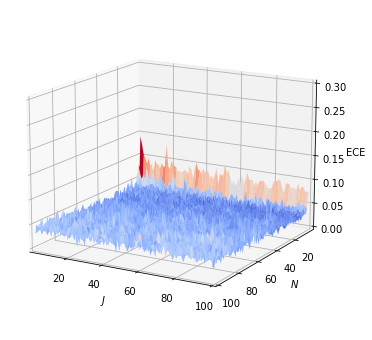

In [73]:
# Plot ECEs

plot_eces_variable(ece_means, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

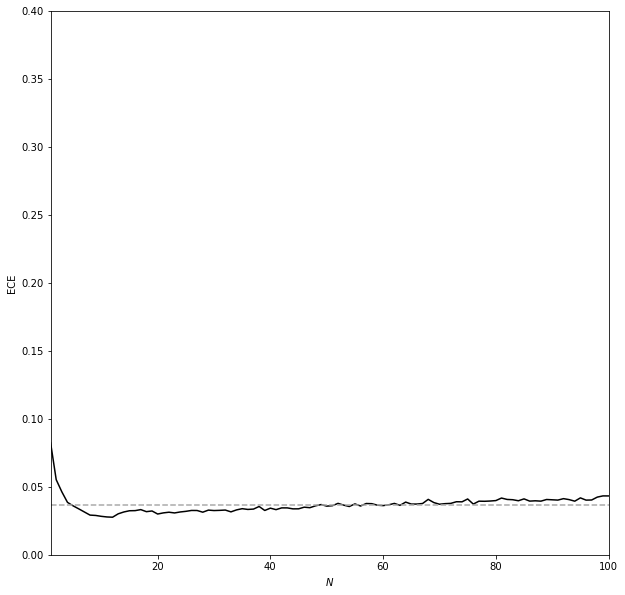

In [28]:
# Plot ECEs only over N (averaged over L)

# Average over L in order to plot over N
ece_means_reshaped = np.reshape(ece_means, (-1, n_clust_max)) # reshape into (#clusters, #observations)
ece_means_over_N = np.mean(ece_means_reshaped, axis = 1)
ece_means_over_N_sd = np.std(ece_means_reshaped, axis = 1)

# Plot
plot_eces_means_over_obs(ece_means_over_N, ece_means_over_N_sd, n_obs_min, n_obs_max)

In [20]:
ece_means_over_N[:5]

array([0.07981659, 0.03685651, 0.02982986, 0.0288946 , 0.03269165])

In [100]:
# Amortized vs non amortized NN for small N's
# Does the problematic behavior of the variable net stem from an Amortization Gap?
print('Mean ECE over all L (more stable) = {}'.format(ece_means_over_N[1:5]))
print('Mean ECE for L=30 (more comparable) = {}'.format(ece_means_reshaped[1:5,29]))
pd.DataFrame([['2','3','4','5'],[0.181, 0.161, 0.185, 0.131],
             [0.035,0.031,0.030,0.025]], index = ['N', 'Amortized NN', 'Non-amortized NN']).transpose()


Mean ECE over all L (more stable) = [0.18186985 0.16163864 0.18543966 0.13194074]
Mean ECE for L=30 (more comparable) = [0.28357073 0.09129752 0.20401547 0.19677951]


,N,Amortized NN,Non-amortized NN
0,2,0.181,0.035
1,3,0.161,0.031
2,4,0.185,0.03
3,5,0.131,0.025


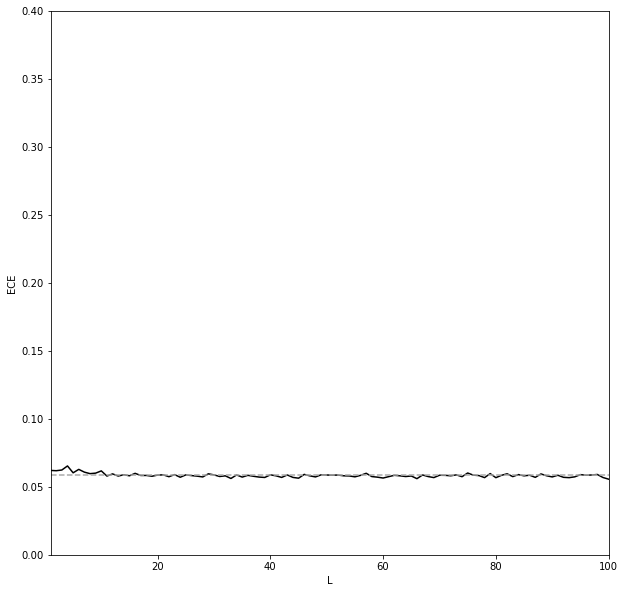

In [47]:
# Inspect pattern over L (averaged over N)
ece_means_reshaped = np.reshape(ece_means, (-1, n_clust_max)) # reshape into (#clusters, #observations)
ece_means_over_N = np.mean(ece_means_reshaped, axis = 0)
ece_means_over_N_sd = np.std(ece_means_reshaped, axis = 0)

# Plot
plot_eces_means_over_obs(ece_means_over_N, ece_means_over_N_sd, n_clust_min, n_clust_max, xlabel = 'L')

# Bridge Sampling Comparison - Bayes Factor Approximation

## Generation of the datasets

In [72]:
# TODO: generate exactly 50 datasets from each model -> np.random.seed(11)

np.random.seed(42)

simulator = MainSimulator(HierarchicalNormalSimulator())

n_val = 100
test_data_bf_true_indices, _, test_data_bf_datasets = simulator(n_val, n_clust_obs_f_f())
test_data_bf = {'X' : test_data_bf_datasets, 'm' : test_data_bf_true_indices}

print('Shape of the simulated datasets (batch_size, n_clusters, n_obs, n_variables): {}'.format(test_data_bf_datasets.shape))

Shape of the simulated datasets (batch_size, n_clusters, n_obs, n_variables): (100, 50, 50, 1)


In [37]:
# save datasets
#np.save('test_data_bf', test_data_bf)
#np.save('test_data_bf_true_indices', test_data_bf_true_indices)
#np.save('test_data_bf_datasets', test_data_bf_datasets)

## Bayes Factor computation by trained NN

In [73]:
def get_preds_and_bfs(evidence_net, summary_net, data, training_time_start, training_time_stop):
    """ 
    Writes model predictions and resulting Bayes Factors for a given 
    array of datasets into a pandas DataFrame. 
    """

    dataset = np.arange(1,data['X'].shape[0]+1)
    true_model = data['m'][:, 1]

    # Predict
    inference_time_start = perf_counter()
    m1_prob = np.array(evidence_net.predict(summary_net(data['X']))['m_probs'][:, 1], dtype = np.longdouble)
    inference_time_stop = perf_counter()
    m0_prob = 1 - m1_prob
    selected_model = (m1_prob > 0.5)

    # Bayes Factors
    bayes_factor = m1_prob / m0_prob
    
    # Times
    training_time = np.repeat((training_time_stop-training_time_start), 100)
    inference_time = np.repeat((inference_time_stop-inference_time_start), 100)
    
    # Final epoch mean loss
    final_epoch_loss = np.repeat(np.mean(losses[10]), 100)

    # Create DataFrame
    vals = np.c_[dataset, true_model, m0_prob, m1_prob, selected_model, bayes_factor,
                 training_time, inference_time, final_epoch_loss]
    names = ['dataset', 'true_model', 'm0_prob', 'm1_prob', 'selected_model', 'bayes_factor',
             'training_time', 'inference_time', 'final_epoch_loss']
    df = pd.DataFrame(vals, columns = names)
    df[["dataset", "true_model", "selected_model"]] = df[["dataset", "true_model", "selected_model"]].astype(int)
    
    return df

In [74]:
comparison_results = get_preds_and_bfs(evidence_net, summary_net, test_data_bf, training_time_start, training_time_stop)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.938310,0.061690,0,0.065746,667.831701,0.016649,0.291394
1,2,1,0.001911,0.998089,1,522.421084,667.831701,0.016649,0.291394
2,3,1,0.001337,0.998663,1,746.981097,667.831701,0.016649,0.291394
3,4,1,0.042312,0.957688,1,22.633909,667.831701,0.016649,0.291394
4,5,0,0.939231,0.060769,0,0.064701,667.831701,0.016649,0.291394


## Exportation of experimental results

In [75]:
# FIXED VARIANT
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_BF_NN_comp')
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)

In [61]:
# VARIABLE VARIANT
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_BF_NN_variable_comp')
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)

# Levy flight application

## Load in data

In [14]:
# TODO: Outsource loading & transformation procedures to helper functions

In [24]:
# 100 trials for pre-training, 900 trials for fine-tuning
levy_sims_folder = 'c:\\Users\\lasse\\documents\\hierarchical model comparison project\\data\\Levy_flight_application'

In [25]:
# 100 trials
indices_100_filename = "train_indices_100_trials.npy"
datasets_100_filename = "train_datasets_100_trials.npy"

indices_100 = np.load(os.path.join(levy_sims_folder, indices_100_filename))
datasets_100 = np.load(os.path.join(levy_sims_folder, datasets_100_filename))

# unpack indices
indices_100 = indices_100[:,0,0,0]-1

# one-hot encode indices
indices_100 = to_categorical(indices_100, num_classes=4)

In [12]:
# 900 trials
indices_900_filename = "train_indices_900_trials.npy"
datasets_900_filename = "train_datasets_900_trials.npy"

indices_900 = np.load(os.path.join(levy_sims_folder, indices_900_filename))
datasets_900 = np.load(os.path.join(levy_sims_folder, datasets_900_filename))

# unpack indices
indices_900 = indices_900[:,0,0,0]-1

# one-hot encode indices
indices_900 = to_categorical(indices_900, num_classes=4)

## Training

In [62]:
# Network settings for all experiments
summary_meta = {
    'level_1': {
        'inv_inner': {
            'dense_inv_pre_pooling_args'  : dict(units=8, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=8, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'inv_outer': {
            'dense_inv_pre_pooling_args'  : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'dense_equiv_args': dict(units=16, activation='elu', kernel_initializer='glorot_normal'),
        'n_dense_equiv': 2,
        'n_equiv': 2,
    },
    'level_2': {
        'inv_inner': {
            'dense_inv_pre_pooling_args'  : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'inv_outer': {
            'dense_inv_pre_pooling_args'  : dict(units=128, activation='elu', kernel_initializer='glorot_normal'),
            'dense_inv_post_pooling_args' : dict(units=128, activation='elu', kernel_initializer='glorot_normal'),
            'n_dense_inv'                 : 2,
        },
        'dense_equiv_args': dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
        'n_dense_equiv': 2,
        'n_equiv': 2,
    },
}
evidence_meta = {
    'dense_args': dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'n_dense': 2,
    'n_models': 4,
    'activation_out': 'softplus'
}

### Pre-training with 100 trials per person

When retraining: Move to new Trial folder so that networks are initialized from scratch.

In [16]:
batch_size = 32

# BayesFlow splits data set into a number of parts equal to batch_size
# So having n_epochs = batch_size results in one pass through the whole data set 
n_epochs = batch_size 

summary_net = HierarchicalInvariantNetwork(summary_meta)
evidence_net = EvidentialNetwork(evidence_meta)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Cosine Decay with Restarts
initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha)

# Checkpoint path for storing pretrained network
trial = 'trial_1'
checkpoint_path = os.path.join(os.getcwd(), 'checkpoints', trial)

trainer = ModelComparisonTrainer(network=amortizer, 
                                 loss=partial(log_loss, kl_weight=0),
                                 optimizer=partial(Adam, lr_schedule_restart),
                                 checkpoint_path=checkpoint_path,
                                 skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\Python code\checkpoints\trial_1\ckpt-32


In [15]:
losses = trainer.train_offline(epochs=n_epochs, batch_size=batch_size, 
                               model_indices=indices_100, sim_data=datasets_100)

Converting 40000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1250 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1250 [00:00<?, ?it/s]

- training time = 62 minutes
- running loss after 32 epochs = 0.469

### Fine-tuning with 900 trials per person

When only conducting fine-tuning: manually move/delete fine-tuning checkpoints in checkpoints folder so that training resumes from pretrained network.

In [63]:
batch_size = 32

# BayesFlow splits data set into a number of parts equal to batch_size
# So having n_epochs = batch_size results in one pass through the whole data set 
n_epochs = batch_size 

summary_net = HierarchicalInvariantNetwork(summary_meta)
evidence_net = EvidentialNetwork(evidence_meta)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Cosine Decay with Restarts
initial_lr = 0.00005 # Shrink LR by factor 10 for fine-tuning
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha)

# Checkpoint path for loading pretrained network and saving the final network
trial = 'trial_1'
checkpoint_path = os.path.join(os.getcwd(), 'checkpoints', trial)

trainer = ModelComparisonTrainer(network=amortizer, 
                                 loss=partial(log_loss, kl_weight=0),
                                 optimizer=partial(Adam, lr_schedule_restart),
                                 checkpoint_path=checkpoint_path,
                                 skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\Python code\checkpoints\trial_1\ckpt-64


In [19]:
losses = trainer.train_offline(epochs=n_epochs, batch_size=batch_size, 
                               model_indices=indices_900, sim_data=datasets_900)

Converting 8000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/250 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/250 [00:00<?, ?it/s]

- training time = 68 minutes
- running loss after 32 epochs = 0.281

## Validation

### Data preparation

In [20]:
# Load in data

levy_sims_folder = 'c:\\Users\\lasse\\documents\\hierarchical model comparison project\\data\\Levy_flight_application'

val_indices_100_filename = "val_indices_100_trials.npy"
val_datasets_100_filename = "val_datasets_100_trials.npy"
val_indices_900_filename = "val_indices_900_trials.npy"
val_datasets_900_filename = "val_datasets_900_trials.npy"

val_indices_100 = np.load(os.path.join(levy_sims_folder, val_indices_100_filename))
val_datasets_100 = np.load(os.path.join(levy_sims_folder, val_datasets_100_filename))
val_indices_900 = np.load(os.path.join(levy_sims_folder, val_indices_900_filename))
val_datasets_900 = np.load(os.path.join(levy_sims_folder, val_datasets_900_filename))

# Split 900 trials into 2 parts so that GPU does not blow up during prediction
val_datasets_900_1 = val_datasets_900[:4000,:,:,:]
val_datasets_900_2 = val_datasets_900[4000:8000,:,:,:]

# unpack indices
val_indices_100 = val_indices_100[:,0,0,0]-1
val_indices_900 = val_indices_900[:,0,0,0]-1

# one-hot encode indices
val_indices_100 = to_categorical(val_indices_100, num_classes=4)
val_indices_900 = to_categorical(val_indices_900, num_classes=4)

In [21]:
# Get & transform predictions & true indices

probs_100 = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'] 
                    for x_chunk in tf.split(val_datasets_100, 500)], axis=0).numpy()
probs_900_1 = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'] 
                    for x_chunk in tf.split(val_datasets_900_1, 500)], axis=0).numpy()
probs_900_2 = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'] 
                    for x_chunk in tf.split(val_datasets_900_2, 500)], axis=0).numpy()
probs_900 = tf.concat([probs_900_1, probs_900_2], axis=0).numpy()

rounded_predictions_100 = tf.one_hot(tf.argmax(probs_100, axis=1), depth=4)
rounded_predictions_900 = tf.one_hot(tf.argmax(probs_900, axis=1), depth=4)

rounded_predictions_flat_100 = tf.argmax(probs_100, axis=1)
rounded_predictions_flat_900 = tf.argmax(probs_900, axis=1)

true_models_flat_100 = tf.argmax(val_indices_100, axis=1)
true_models_flat_900 = tf.argmax(val_indices_900, axis=1)

In [22]:
# Export predictions
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_predictions_finetuned_900')
val_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'Levy_flight_application')

np.save(os.path.join(val_folder, filename), probs_900)

In [ ]:
# Load in predictions

# TODO

### Results

In [24]:
# Accuracy & MAE
accuracy = tf.reduce_sum(tf.cast(rounded_predictions_flat_900 == true_models_flat_900, tf.float32))/len(true_models_flat_900)
mae = mean_absolute_error(val_indices_900, probs_900)
print('Accuracy = {}, MAE = {}'.format(accuracy, mae))

Accuracy = 0.8702499866485596, MAE = 0.09256470203399658


Text(23.499999999999993, 0.5, 'True underlying model')

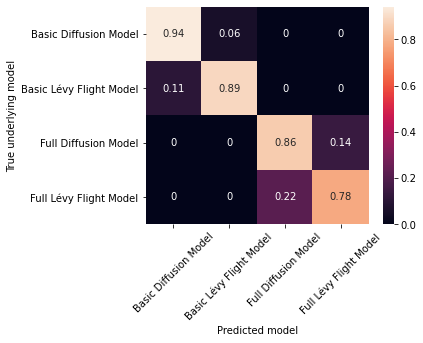

In [25]:
# Confusion matrix 

cm = confusion_matrix(true_models_flat_900, rounded_predictions_flat_900)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = cm.round(2)

labels = ['Basic Diffusion Model',
          'Basic Lévy Flight Model',
           'Full Diffusion Model',
           'Full Lévy Flight Model',]
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True)
plt.xticks(rotation=45)
plt.xlabel('Predicted model')
plt.ylabel('True underlying model')
#plt.savefig('Diffusion_conf_matrix.png', dpi=300, bbox_inches='tight')

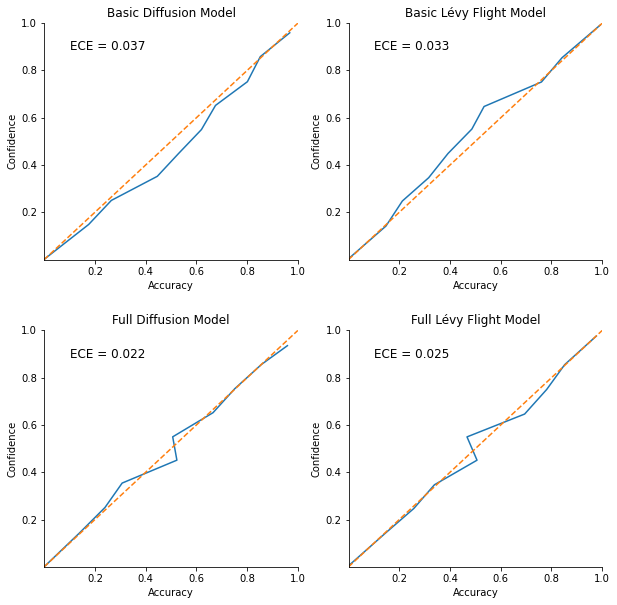

In [30]:
# Calibration curves

fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
n_cal_bins = 15
plt.subplots_adjust(hspace = .3)
pos1 = [0,0,1,1]
pos2 = [0,1,0,1]
labels = ['Basic Diffusion Model',
          'Basic Lévy Flight Model',
           'Full Diffusion Model',
           'Full Lévy Flight Model',]

for m in range(4):
    m_true = val_indices_900[:,m]
    m_soft = probs_900[:,m]
    plot_calibration_curve(m_true, m_soft, 10, 
                           axarr[pos1[m], pos2[m]], title=labels[m])

## Application to real data

In [58]:
# Load and transform data

# Expected shape: (1, 40, 900, 3) 
# Example output: [1.        , 0.93565676, 1.        ]
# stimulus_type, rt, decision

def load_from_folder(load_dir):
    """
    Reads single subject datasets from a folder and transforms into list of 4D-arrays 
    which allows for a variable number of observations between participants.
    Assumes data files have a three-column csv format (Condition, Response, Response Time).
    ----------
    
    Arguments:
    load_dir : str -- a string indicating the directory from which to load the data
    --------
        
    Returns:
    X: list of length (n_clusters), containing tf.Tensors of shape (1, 1, n_obs, 3) 
        -- variable order now (Condition, Response Time, Response)
    """
    
    data_files = os.listdir(load_dir)
    X = []
    
    # Loop through data files and estimate
    for data_file in data_files:
        
        ### Read in and transform data
        data = pd.read_csv(os.path.join(load_dir, data_file), header=None, sep=' ')
        data = data[[0,2,1]].values # reorder columns
        X_file = tf.convert_to_tensor(data, dtype=tf.float32)[np.newaxis][np.newaxis] # get 4D tensor
        X.append(X_file)
      
    return X

In [102]:
# Load data from folders

parent_folder = os.path.dirname(os.getcwd())
color_folder = os.path.join(parent_folder, 'data\\Levy_flight_application\\data_rts\\color')
lexical_folder = os.path.join(parent_folder, 'data\\Levy_flight_application\\data_rts\\lexical')

color_data = load_from_folder(color_folder)
lexical_data = load_from_folder(lexical_folder)

In [103]:
# Join experimental data

n_clusters = len(color_data)
empirical_data = []

for cluster in range(n_clusters):
    joint_data = tf.concat([color_data[cluster], lexical_data[cluster]], axis=2).numpy()
    empirical_data.append(joint_data)

In [110]:
# Reduce variable size datasets to fixed length summary vectors, then join into single 3D tensor
summarized_data = []

for cluster in range(n_clusters):
    summarized_cluster = summary_net(empirical_data[cluster])
    summarized_data.append(summarized_cluster)

summarized_data = tf.convert_to_tensor(summarized_data)
summarized_data = tf.reshape(summarized_data, shape=(1, n_clusters, summarized_data.shape[2]))

In [112]:
summarized_data.shape

TensorShape([1, 40, 130])

In [111]:
evidence_net.predict(summarized_data)

# This sequential approach does not work as summary network reduces from 4D to 2D data, which requires feeding in all clusters at once!

{'m_probs': array([[[0.00051637, 0.02918763, 0.00800159, 0.00538307],
         [0.00051644, 0.02199042, 0.00800159, 0.00538307],
         [0.00051637, 0.02482419, 0.00800159, 0.00538307],
         [0.00051637, 0.01895292, 0.00800159, 0.00538307],
         [0.00051637, 0.07514445, 0.00800159, 0.00538307],
         [0.00051637, 0.03312628, 0.00800159, 0.00538307],
         [0.01392228, 0.01545576, 0.00800159, 0.00538307],
         [0.00051637, 0.02235707, 0.00800159, 0.00538307],
         [0.00051637, 0.02195396, 0.00800159, 0.00538307],
         [0.00051637, 0.04668735, 0.00800159, 0.00538307],
         [0.00051637, 0.00002565, 0.68639106, 0.4745728 ],
         [0.00051637, 0.0315997 , 0.00800159, 0.00538307],
         [0.00051637, 0.02425586, 0.00800159, 0.00538307],
         [0.26165357, 0.00223879, 0.00800159, 0.00538307],
         [0.02955761, 0.01511965, 0.00800159, 0.00538307],
         [0.15276736, 0.00396891, 0.00800159, 0.00538307],
         [0.00051637, 0.02578303, 0.00800159,

## Visualize model comparison results

In [69]:
probs[15000:15050,:]

array([[0.00170894, 0.00170894, 0.09262215, 0.90396   ],
       [0.00074346, 0.00074346, 0.00269924, 0.9958139 ],
       [0.00146696, 0.00146696, 0.00146696, 0.99559915],
       [0.000823  , 0.000823  , 0.000823  , 0.997531  ],
       [0.00109269, 0.00109269, 0.3616679 , 0.6361467 ],
       [0.00131404, 0.00131404, 0.00131404, 0.99605787],
       [0.00199702, 0.00199702, 0.29393634, 0.7020696 ],
       [0.00098333, 0.00098333, 0.4503833 , 0.54765004],
       [0.00161997, 0.00161997, 0.0821996 , 0.9145605 ],
       [0.00169285, 0.00169285, 0.01422751, 0.9823868 ],
       [0.00142255, 0.00142255, 0.07457791, 0.92257696],
       [0.00129661, 0.00129661, 0.00129661, 0.9961102 ],
       [0.00130267, 0.00130267, 0.6663192 , 0.33107543],
       [0.00309698, 0.18870306, 0.00309698, 0.80510294],
       [0.00110066, 0.00110066, 0.5683778 , 0.42942092],
       [0.00139576, 0.00139576, 0.09450055, 0.9027079 ],
       [0.00088571, 0.00088571, 0.00107242, 0.99715614],
       [0.0022778 , 0.0022778 ,

In [70]:
# Violin plot on a validation dataset

example_dataset = val_datasets[15006:15007,:,:,:]

example_preds = evidence_net.predict(summary_net(example_dataset))

In [71]:
example_preds

{'m_probs': array([[0.00199722, 0.00199722, 0.29398242, 0.70202315]], dtype=float32),
 'm_var': array([[0.00000397, 0.00000397, 0.00041371, 0.00041696]], dtype=float32),
 'uncertainty': array([[0.00798889]], dtype=float32)}

In [72]:
example_evidences = evidence_net(summary_net(example_dataset))

In [73]:
example_evidences

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[  1.     ,   1.     , 147.19568, 351.49985]], dtype=float32)>

In [74]:
example_dirichlet = evidence_net.sample(summary_net(example_dataset),10000)
example_dirichlet = np.squeeze(example_dirichlet)

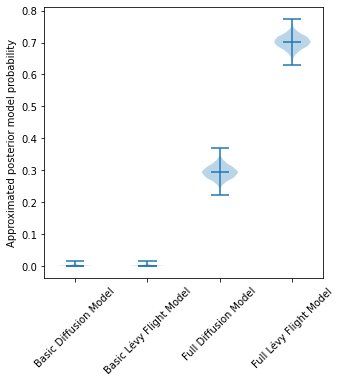

In [134]:
fig, ax = plt.subplots(figsize=(5,5))
labels = ['Basic Diffusion Model',
          'Basic Lévy Flight Model',
           'Full Diffusion Model',
           'Full Lévy Flight Model',]

ax.violinplot(np.squeeze(example_dirichlet), showmedians=True)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Approximated posterior model probability')
fig.savefig('Diffusion_violin_plot.png', dpi=300, bbox_inches='tight')